In [2]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import pandas as pd
import os

In [9]:
def parse_ip_port(hex_ip, port):
    """Parses a hexadecimal IP and port to a human-readable string."""
    try:
        # ip = '.'.join(str(int(hex_ip[i:i+2], 16)) for i in range(0, 8, 2))
        # return f"{ip}:{port}"
        # return f"{ip}"
        
        ip_list=[str(int(hex_ip[i:i+2], 16)) for i in range(0, 8, 2)]
        return f"Host-{ip_list[2]}"
        
    except ValueError as e:
        print(f"Error parsing IP:Port - {hex_ip}:{port}")
        return "0.0.0.0:0"

dict_keys([('Host-1', 'Host-2'), ('Host-0', 'Host-2')])


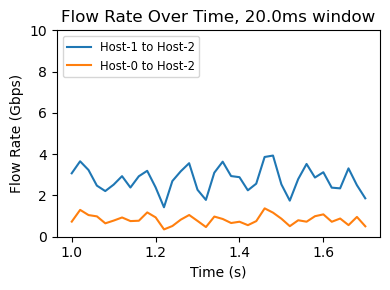

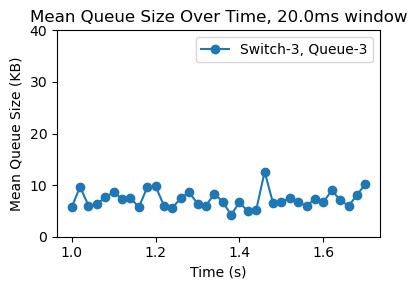

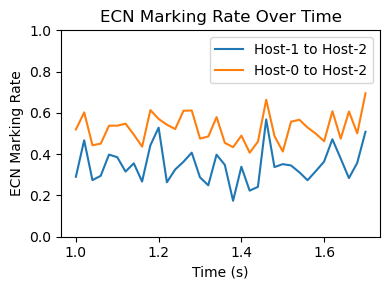

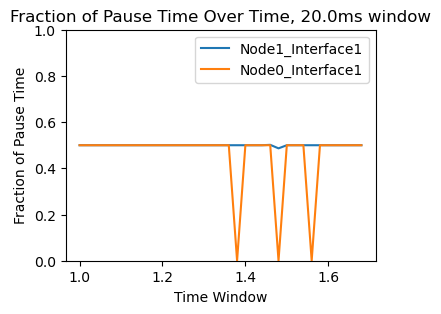

/tmp/ipykernel_3545180/38907387.py:275: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(top=drop_top, bottom=drop_bottom)


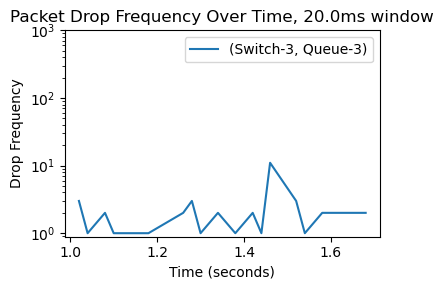

In [31]:
shard=0
# data_dir_str='_pfc'
# data_dir_str='_bfsz'
data_dir_str='_hpai'
data_dir=f"/data2/lichenni/path_tc_test/shard{shard}_nflows4000_nhosts3_lr10Gbps{data_dir_str}"
shard_seed=0
# Calculate stats using a 1ms window
window_size_ns = 20*1e6  # 1ms in nanoseconds
# Read and parse the log file
log_file_path = f'{data_dir}/tr_s{shard_seed}.log'  # Replace with your actual log file path
flow_rate_top=10
flow_rate_bottom=0
queue_size_top=40
queue_size_bottom=0
ecn_mark_top = 1.0  # Maximum value for the y-axis
ecn_mark_bottom = 0.0  # Minimum value for the y-axis
pfc_top = 1  # Maximum value for the y-axis
pfc_bottom = 0.0  # Minimum value for the y-axis
drop_top = 1000  # Maximum value for the y-axis
drop_bottom = 0.0  # Minimum value for the y-axis

if not os.path.exists(log_file_path):
    os.system(f"./trace_reader {data_dir}/mix_topo-pl-3_s{shard_seed}.tr > {log_file_path}")

# Initialize data structures
flow_packets =  defaultdict(lambda: {'total_bytes': [], 'timestamps': []})
 # Key: (src, dst), Value: list of timestamps (ns)
ecn_marks = defaultdict(list)  # Timestamps of ECN-marked packets
queue_sizes = defaultdict(list)  # Key: (node, port, queue), Value: list of (timestamp, queue size) tuples
with open(log_file_path, 'r') as file:
    for line in file:
        parts = line.split()
        
        event_type = parts[4]  # Assuming the event type is at this position
        pkt_type = parts[10]  # Assuming the packet type is at this position
        node = parts[1].split(':')[1]
        port, queue = map(int, parts[2].split(':'))
        
        timestamp_ns = int(parts[0])
        
        src = parse_ip_port(parts[6], parts[8])
        dst = parse_ip_port(parts[7], parts[9])
            
        if node=='3' and (event_type == "Enqu" or event_type == "Dequ"):
            
            queue_size = float(parts[3])
            # Store queue size by node, port, and queue
            # queue_sizes[(node, port, queue)].append((timestamp_ns, queue_size))
            queue_sizes[(node, queue)].append((timestamp_ns, queue_size))
            
        if node=='3' and (event_type == "Dequ" and pkt_type=='U'):  # Change "recv" to the actual keyword for receive events
            ecn_marked = 1 if parts[5].split(':')[1]!='0' else 0
            ecn_marks[(src, dst)].append([timestamp_ns,ecn_marked])
            
        if node=='2' and (event_type == "Recv"):  # Change "recv" to the actual keyword for receive events
            
            packet_size = int(parts[-1].split('(')[-1][:-1])
            # Store packet timestamp by flow
            flow_packets[(src, dst)]['total_bytes'].append(packet_size)
            flow_packets[(src, dst)]['timestamps'].append(timestamp_ns)
        
flow_rates = defaultdict(list)  # Key: (src, dst), Value: list of (timestamp, rate) tuples

print(flow_packets.keys())
for (src, dst), data in flow_packets.items():
    sorted_indices = sorted(range(len(data['timestamps'])), key=lambda i: data['timestamps'][i])
    start_time = data['timestamps'][sorted_indices[0]]
    end_time = data['timestamps'][sorted_indices[-1]]
    
    current_window_start = start_time
    while current_window_start <= end_time:
        window_end = current_window_start + window_size_ns
        window_bytes = sum(data['total_bytes'][i] for i in sorted_indices if current_window_start <= data['timestamps'][i] < window_end)
        window_rate_gbps = (window_bytes * 8) / (window_size_ns / 1e9) / 1e9  # Convert to Mbps
        flow_rates[(src, dst)].append((current_window_start, window_rate_gbps))
        current_window_start += window_size_ns

# Plot flow rates over time for a selected flow (for simplicity, plot the first flow)
plt.figure(figsize=(4, 3))
# Iterate over each flow and plot its flow rate over time
for flow_id, rates in flow_rates.items():
    times, rates = zip(*rates)
    plt.plot(np.array(times) / 1e9, rates, label=f"{flow_id[0]} to {flow_id[1]}")

plt.xlabel('Time (s)')
plt.ylabel('Flow Rate (Gbps)')
plt.ylim(top=flow_rate_top,bottom=flow_rate_bottom)
plt.title(f'Flow Rate Over Time, {window_size_ns/1e6}ms window')
plt.legend(loc='upper left', fontsize='small')  # Adjust legend placement
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

# Plot queue size over time for a specific queue (for simplicity, plot the first queue)
# Calculate mean queue size in each window
mean_queue_sizes = defaultdict(list)  # New dictionary for mean queue sizes
for key, values in queue_sizes.items():
    # Convert list of tuples to a structured NumPy array for efficient processing
    dtype = [('timestamp', 'i8'), ('size', 'f8')]
    data = np.array(values, dtype=dtype)
    
    # Sort the data by timestamp
    data.sort(order='timestamp')
    
    # Determine the range of timestamps
    start_time = data['timestamp'][0]
    end_time = data['timestamp'][-1] + window_size_ns  # Ensure the last window is included
    
    # Create an array of window start times
    windows = np.arange(start_time, end_time, window_size_ns)
    
    # Digitize the timestamps to find out which window each timestamp belongs to
    indices = np.digitize(data['timestamp'], windows)
    
    # Calculate mean size for each window
    for window_start in np.unique(indices):
        window_data = data['size'][indices == window_start]
        if window_data.size > 0:
            mean_size = window_data.mean()
            # Use the start of each window as the timestamp for the mean value
            mean_queue_sizes[key].append((windows[window_start-1], mean_size))
         
selected_queue = list(mean_queue_sizes.keys())[0]
timestamps, mean_sizes = zip(*mean_queue_sizes[selected_queue])
plt.figure(figsize=(4, 3))
# plt.plot(np.array(timestamps) / 1e9, np.array(mean_sizes) / 1024, '-o', label=f"Switch-{selected_queue[0]}, Port-{selected_queue[1]}, Queue-{selected_queue[2]}")
plt.plot(np.array(timestamps) / 1e9, np.array(mean_sizes) / 1024, '-o', label=f"Switch-{selected_queue[0]}, Queue-{selected_queue[1]}")
plt.xlabel('Time (s)')
plt.ylabel('Mean Queue Size (KB)')
plt.ylim(top=queue_size_top,bottom=queue_size_bottom)
plt.title(f'Mean Queue Size Over Time, {window_size_ns/1e6}ms window')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate ECN marking rate
ecn_mark_rates = defaultdict(list)

for flow_id, packets in ecn_marks.items():
    packets.sort(key=lambda x: x[0])
    
    start_time = packets[0][0]
    end_time = packets[-1][0]
    current_window_start = start_time
    while current_window_start <= end_time:
        window_packets = [mark for ts, mark in packets if current_window_start <= ts < current_window_start + window_size_ns]
        if window_packets:  # Avoid division by zero
            mark_rate = sum(window_packets) / len(window_packets)
            ecn_mark_rates[flow_id].append((current_window_start, mark_rate))
        else:
            ecn_mark_rates[flow_id].append((current_window_start, 0))
        current_window_start += window_size_ns
# Plot ECN marking rate over time for a selected flow
plt.figure(figsize=(4, 3))

for flow_id, rates in ecn_mark_rates.items():
    times, rates = zip(*rates)
    plt.plot(np.array(times) / 1e9, rates, label=f"{flow_id[0]} to {flow_id[1]}")
    
# plt.plot(np.array(times) / 1e9, rates, '-o', label=f"Switch-{selected_queue[0]}, Port-{selected_queue[1]}, Queue-{selected_queue[2]}")
plt.xlabel('Time (s)')
plt.ylabel('ECN Marking Rate')
plt.ylim(top=ecn_mark_top, bottom=ecn_mark_bottom)
plt.title('ECN Marking Rate Over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Assuming the log file is named 'pfc_log.txt'
log_file_path = f'{data_dir}/pfc_topo-pl-3_s{shard_seed}.txt'

# Parse the log file
data = []
with open(log_file_path, 'r') as file:
    for line in file:
        parts = line.split()
        timestamp = int(parts[0])
        node_id = int(parts[1])
        interface_index = int(parts[3])
        pfc_event = int(parts[4])
        data.append((timestamp, node_id, interface_index, pfc_event))

# Check if the DataFrame is empty
if not data:
    print("The log file is empty. Stopping execution.")
else:   
    # Sort the data by timestamp
    data.sort(key=lambda x: x[0])

    # Create an empty dictionary to store PFC events for each node and interface
    pfc_events = {}

    # Iterate over the data to group PFC events by node and interface
    for timestamp, node_id, interface_index, pfc_event in data:
        key = (node_id, interface_index)
        if key not in pfc_events:
            pfc_events[key] = []
        pfc_events[key].append((timestamp, pfc_event))

    # Calculate the fraction of PFC events for each node and interface
    result_dict = {}
    for key, events in pfc_events.items():
        window_start = events[0][0]
        window_end = window_start + window_size_ns
        pfc_event_count = []
        while window_end <= events[-1][0]:
            events_in_window = [event[1] for event in events if window_start <= event[0] < window_end]
            total_events_in_window = len(events_in_window)
            if total_events_in_window == 0:
                pfc_event_count.append(0)
            else:
                pfc_event_count.append(sum(events_in_window) / total_events_in_window)
            window_start = window_end
            window_end += window_size_ns
        result_dict[key] = pfc_event_count
    # Plot the fraction of PFC events for each node and interface
    plt.figure(figsize=(4, 3))
    for key, fraction in result_dict.items():
        time_seconds = [1+i * window_size_ns/1e9 for i in range(len(fraction))]
        plt.plot(time_seconds, fraction, label=f'Node{key[0]}_Interface{key[1]}')

    plt.xlabel('Time Window')
    plt.ylabel('Fraction of Pause Time')
    plt.title(f'Fraction of Pause Time Over Time, {window_size_ns/1e6}ms window')
    plt.ylim(top=pfc_top, bottom=pfc_bottom)
    plt.legend()
    # plt.grid(True)
    plt.show()

# Read the log file and extract drop events with node, port, and queue information
log_file_path = f'{data_dir}/pdrop_topo-pl-3_s{shard_seed}.txt'
drop_events = []
with open(log_file_path, 'r') as file:
    for line in file:
        if 'Drop: queue' in line:
            parts = line.split()
            timestamp = int(parts[0])
            node_id = int(parts[1])
            port_queue_part = parts[3].split(':')[1]  # Extract "queue:1,3" part
            port = int(port_queue_part.split(',')[0])
            queue = int(port_queue_part.split(',')[1])
            drop_events.append((timestamp, node_id, port, queue))

# Check if the drop_events list is empty
# Check if the drop_events list is empty
if not drop_events:
    print("No drop events found in the log file. Stopping execution.")
else:
    # Dictionary to store drop frequency for each (node, port, queue) combination
    drop_frequency = {}

    # Iterate over drop events and calculate drop frequency for each time window and combination
    for timestamp, node_id, port, queue in drop_events:
        time_bucket = timestamp // window_size_ns  # Convert timestamp to seconds
        # key = (node_id, port, queue)
        key = (node_id, queue)
        if key not in drop_frequency:
            drop_frequency[key] = {}
        if time_bucket not in drop_frequency[key]:
            drop_frequency[key][time_bucket] = 0
        drop_frequency[key][time_bucket] += 1

    # Plot drop frequency over time for each unique (node, port, queue) combination
    plt.figure(figsize=(4, 3))
    # for (node_id, port, queue), time_buckets in drop_frequency.items():
    for (node_id, queue), time_buckets in drop_frequency.items():
        timestamps = [tb * window_size_ns/1e9 for tb in sorted(time_buckets.keys())]
        frequencies = [time_buckets[tb] for tb in sorted(time_buckets.keys())]
        # plt.plot(timestamps, frequencies, label=f'(Switch-{node_id}, Port-{port}, Queue-{queue})')
        plt.plot(timestamps, frequencies, label=f'(Switch-{node_id}, Queue-{queue})')

    plt.xlabel('Time (seconds)')
    plt.ylabel('Drop Frequency')
    plt.title(f'Packet Drop Frequency Over Time, {window_size_ns/1e6}ms window')
    plt.yscale('log')
    plt.ylim(top=drop_top, bottom=drop_bottom)
    plt.legend()
    plt.tight_layout()
    plt.show()

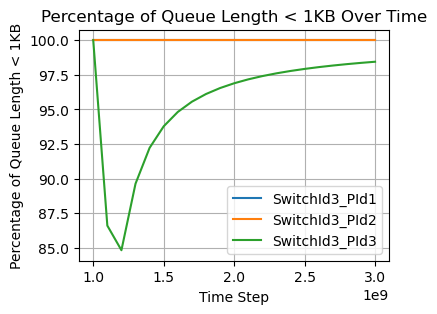

In [40]:
# Function to parse the log data
def parse_log(log_file):
    data = {"Time Step": [], "Queue ID": [], "Queue Lengths": []}
    with open(log_file, "r") as f:
        for line in f:
            if line.startswith("time:"):
                time_step = int(line.split(":")[1])
            else:
                parts = line.split()
                switch_id = int(parts[0])
                device_id = int(parts[1])
                queue_lengths = list(map(int, parts[2:]))
                data["Time Step"].append(time_step)
                data["Queue ID"].append(f"SwitchId{switch_id}_PId{device_id}")
                data["Queue Lengths"].append(queue_lengths)
    return pd.DataFrame(data)

# Function to calculate percentage of queue length < 1KB
def calculate_percentage(df):
    df["Percentage < 1KB"] = df["Queue Lengths"].apply(lambda x: sum(x[:1]) / sum(x) * 100)
    return df

# Function to plot the percentage over time for each node
def plot_percentage(df):
    plt.figure(figsize=(4, 3))
    for node_id in df["Queue ID"].unique():
        node_data = df[df["Queue ID"] == node_id]
        plt.plot(node_data["Time Step"], node_data["Percentage < 1KB"], label=f"{node_id}")
    plt.xlabel("Time Step")
    plt.ylabel("Percentage of Queue Length < 1KB")
    plt.title("Percentage of Queue Length < 1KB Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
log_file = f"{data_dir}/qlen_topo-pl-3_s{shard_seed}.txt"
log_data = parse_log(log_file)
log_data_with_percentage = calculate_percentage(log_data)
plot_percentage(log_data_with_percentage)
